In [1]:
import sys, os
sys.path.append('src/')

import numpy as np
import umap_batch
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scipy.sparse as sp

import model
import utils
import bmk

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.rcParams["font.size"] = 10



## Step 1: Load dataset
Make sure that the dataset get stored in a dictionary (`counts` in the script), with the item:
* `nbatches`: total number of batches
* `feats_name`: a dictionary storing the feature names for different modalities, e.g. `{"rna": np.array([aaaa, bbbb,...]), "atac": np.array([ccc, ddd, ...]), "protein": np.array([eee, fff, ...])}`
* `modality 1` (e.g. `rna` in the example below): a `list` store all data matrices correspond to modality 1, a element correspond to one batch, elements are ordered in the list following the ordering of batches. **The batches that does not have count matrix in corresponding modality is inserted `None` as placeholder**
* `modality 2` (e.g. `atac` in the example below): requirement the same as above.
* `modality 3` (e.g. `protein`): requirement the same as above.
* ...

#### Note:
* The number of item in the `feats_name` should match the number of modalities in `counts`. 
* The length of lists in `modality 1`, `modality 2`, `modality 3`, etc should have the same length, which is equal to `nbatches`. (missing matrices are denoted as `None` as explained above). **The matrices must be ordered according to the batch ID in each list,** so that scMoMaT can detact parallel sequenced batches.
* The data matrix in each modality (each list) should have the same set of features. You can do thie by 1. using the intersection of all genes/proteins in different batches; 2. Remap the chromatin regions according to the peaks of one batch. 
* The data matrix is of the shape `(ncells, nfeatures)`, and preprocessed with `utils.preprocess()` function.

One example template is shown as below, note that the features of data matrices are matched in advance. The connection matrix (`GxR.npz`) that is used to generate pseudo-count is also provided in advance (used the code in folder `calc_pseudo_count/calc_pseudo_count.R`). Feel free to modify on the template to use your dataset.


In [3]:
dir = "./data/real/MOp_5batches/"

n_batches = 5
counts_rnas = []
counts_atacs = []
labels_ori = []
labels_trans = []
labels_remap = []
for batch in range(n_batches):
    # NOTE: read in remapped labels
    label = pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster (remapped)"].values.squeeze()        
    labels_remap.append(label)
    # NOTE: read in the count matrices    
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch + 1) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")
        print("read atac for batch" + str(batch + 1))

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch + 1) + ".npz")).todense().T)
        print("read rna for batch" + str(batch + 1))
        counts_rna = utils.preprocess(counts_rna, modality = "RNA", log = False)

    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())

# CALCULATE PSEUDO-SCRNA-SEQ
counts["rna"][2] = counts["atac"][2] @ A.T
#BINARIZE, still is able to see the cluster pattern, much denser than scRNA-Seq (cluster pattern clearer)
counts["rna"][2] = (counts["rna"][2]!=0).astype(int)

# CALCULATE PSEUDO-SCRNA-SEQ
counts["rna"][4] = counts["atac"][4] @ A.T
#BINARIZE, still is able to see the cluster pattern, much denser than scRNA-Seq (cluster pattern clearer)
counts["rna"][4] = (counts["rna"][4]!=0).astype(int)

# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name
counts["nbatches"] = n_batches

read atac for batch1
read rna for batch1
read rna for batch2
read atac for batch3
read rna for batch4
read atac for batch5


## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 400.9384
	 loss reconstruction: 0.40022
	 loss regularization: 0.72000
Epoch 1000, Validating Loss: 285.6614
	 loss reconstruction: 0.28560
	 loss regularization: 0.05898
Epoch 2000, Validating Loss: 281.0053
	 loss reconstruction: 0.28097
	 loss regularization: 0.03670
Epoch 3000, Validating Loss: 279.3572
	 loss reconstruction: 0.27932
	 loss regularization: 0.03563
Epoch 4000, Validating Loss: 278.3959
	 loss reconstruction: 0.27837
	 loss regularization: 0.02659
running time: 183.516010761261


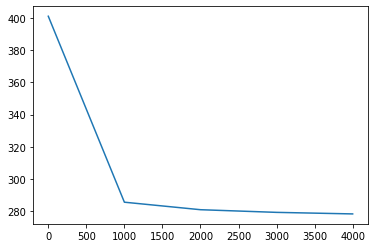

In [4]:
# NOTE: Running scmomat
# weight on regularization term
lamb = 0.001
batchsize = 0.1
# running seed
seed = 0
# number of latent dimensions
K = 30
interval = 1000
T = 4000
lr = 1e-2

start_time = time.time()
model1 = model.scmomat(counts = counts, K = K, batch_size = batchsize, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

# Plot loss function
x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses1)

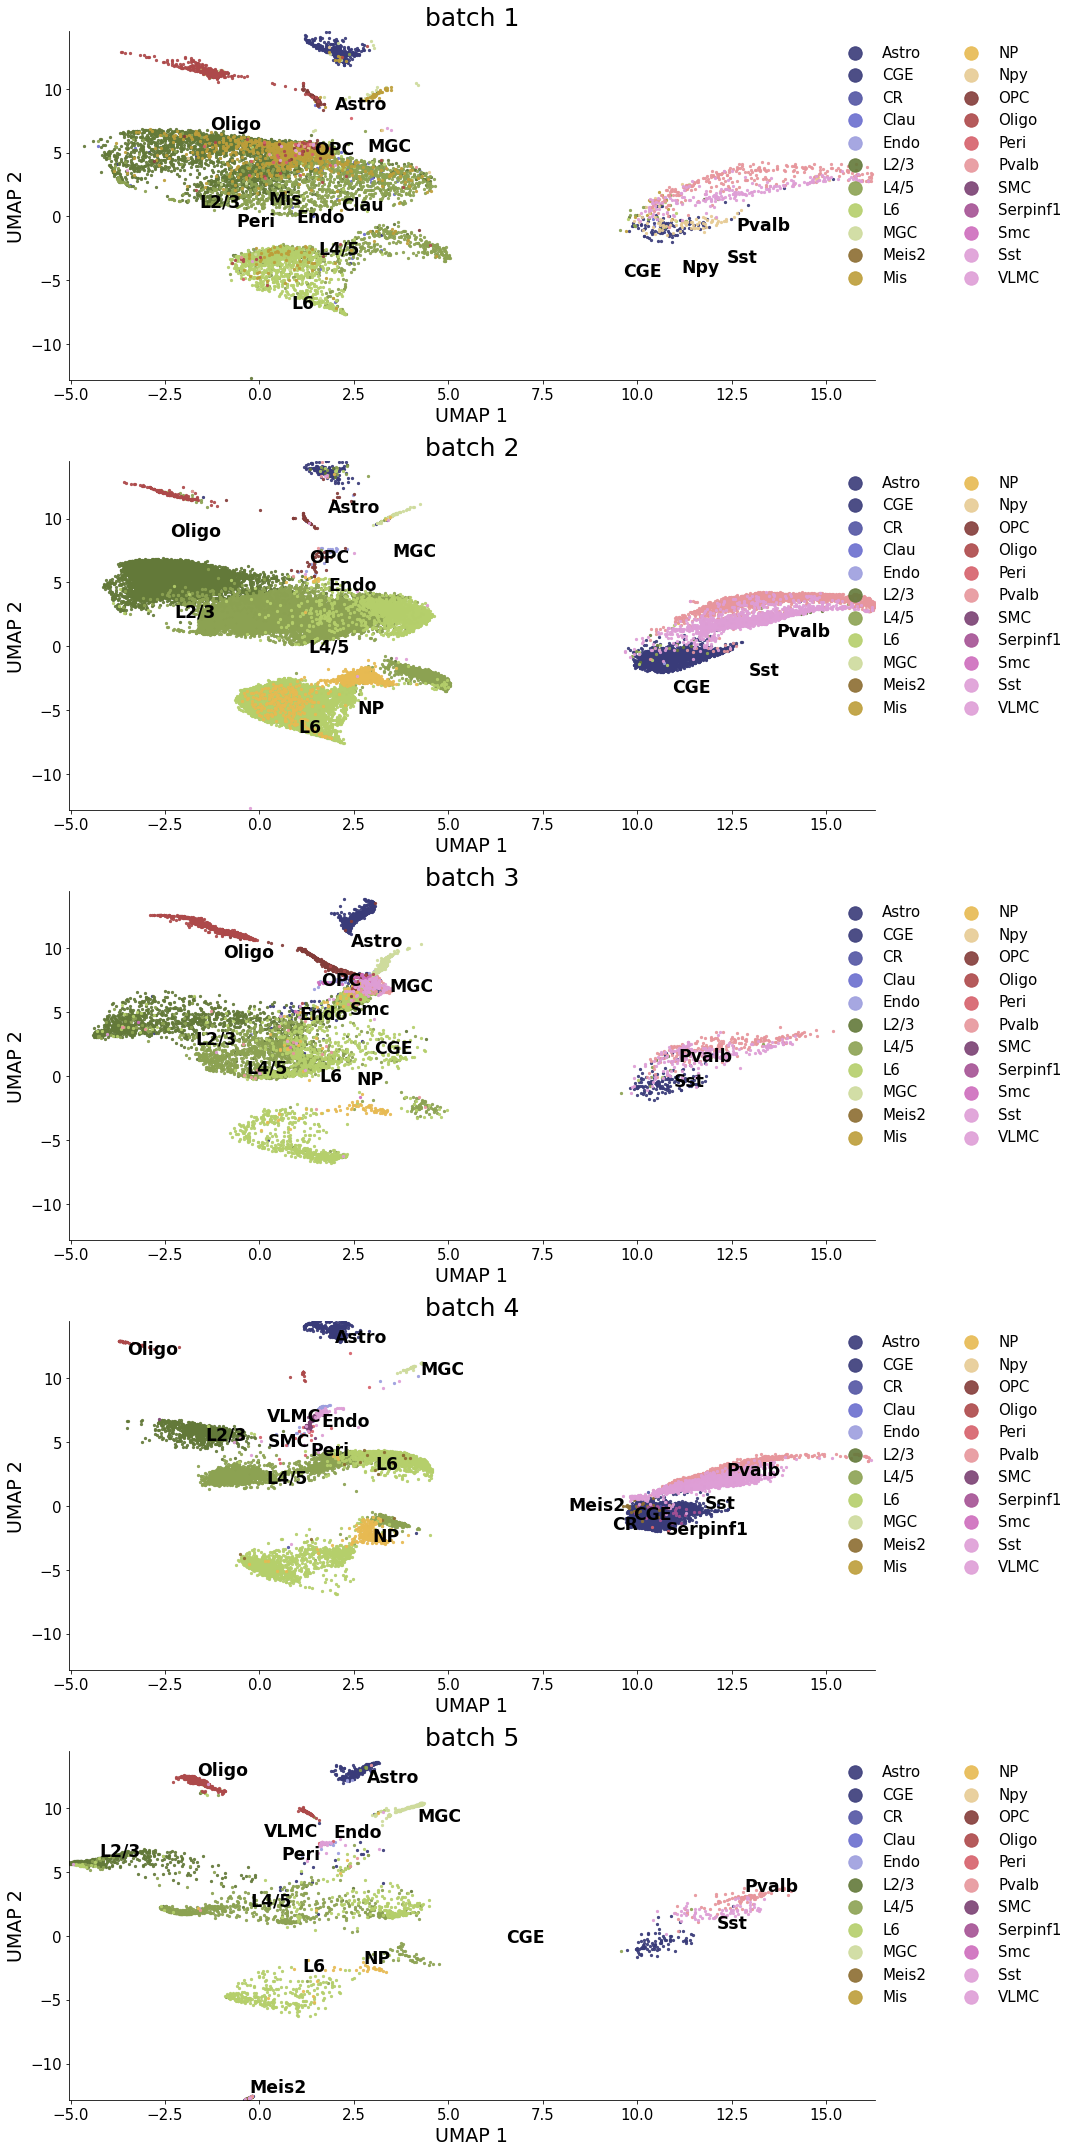

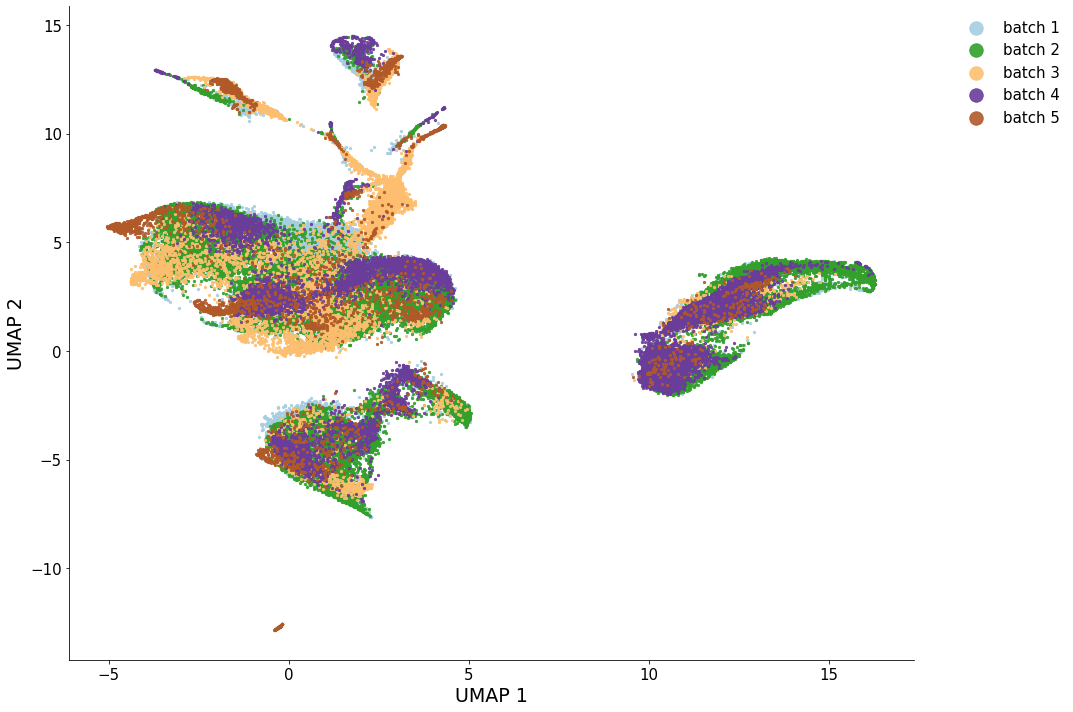

In [5]:
# NOTE: Plot the result before post-processing
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = []
for batch in range(n_batches):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    zs.append(z)
    
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

# separate into batches
x_umaps = []
for batch in range(n_batches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        
    elif batch == (n_batches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
        
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels_remap, mode = "separate", save = None, figsize = (15,30), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
utils.plot_latent_ext(x_umaps, annos = labels_remap, mode = "modality", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)


## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

calculating pairwise distance, time used 19.4013s
knn separate, time used 17.4025s
modify distance 1, time used 0.0268s
modify distance 2, time used 41.1628s


/localscratch/ziqi/CFRM/src/umap_batch.py:1746: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


not unique
using precompute
Provided KNN...


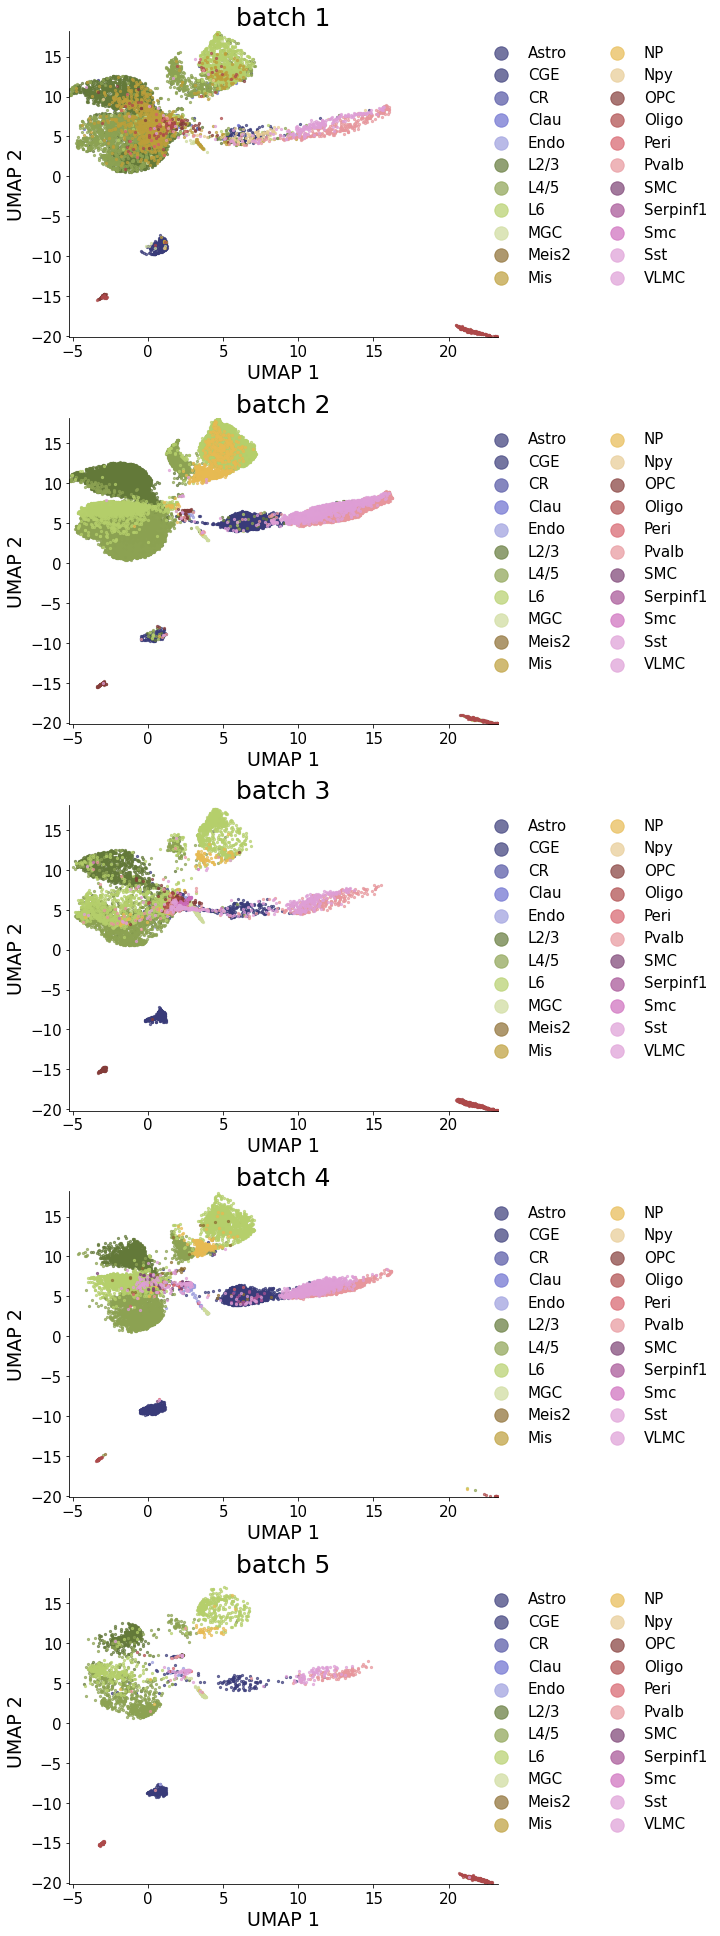

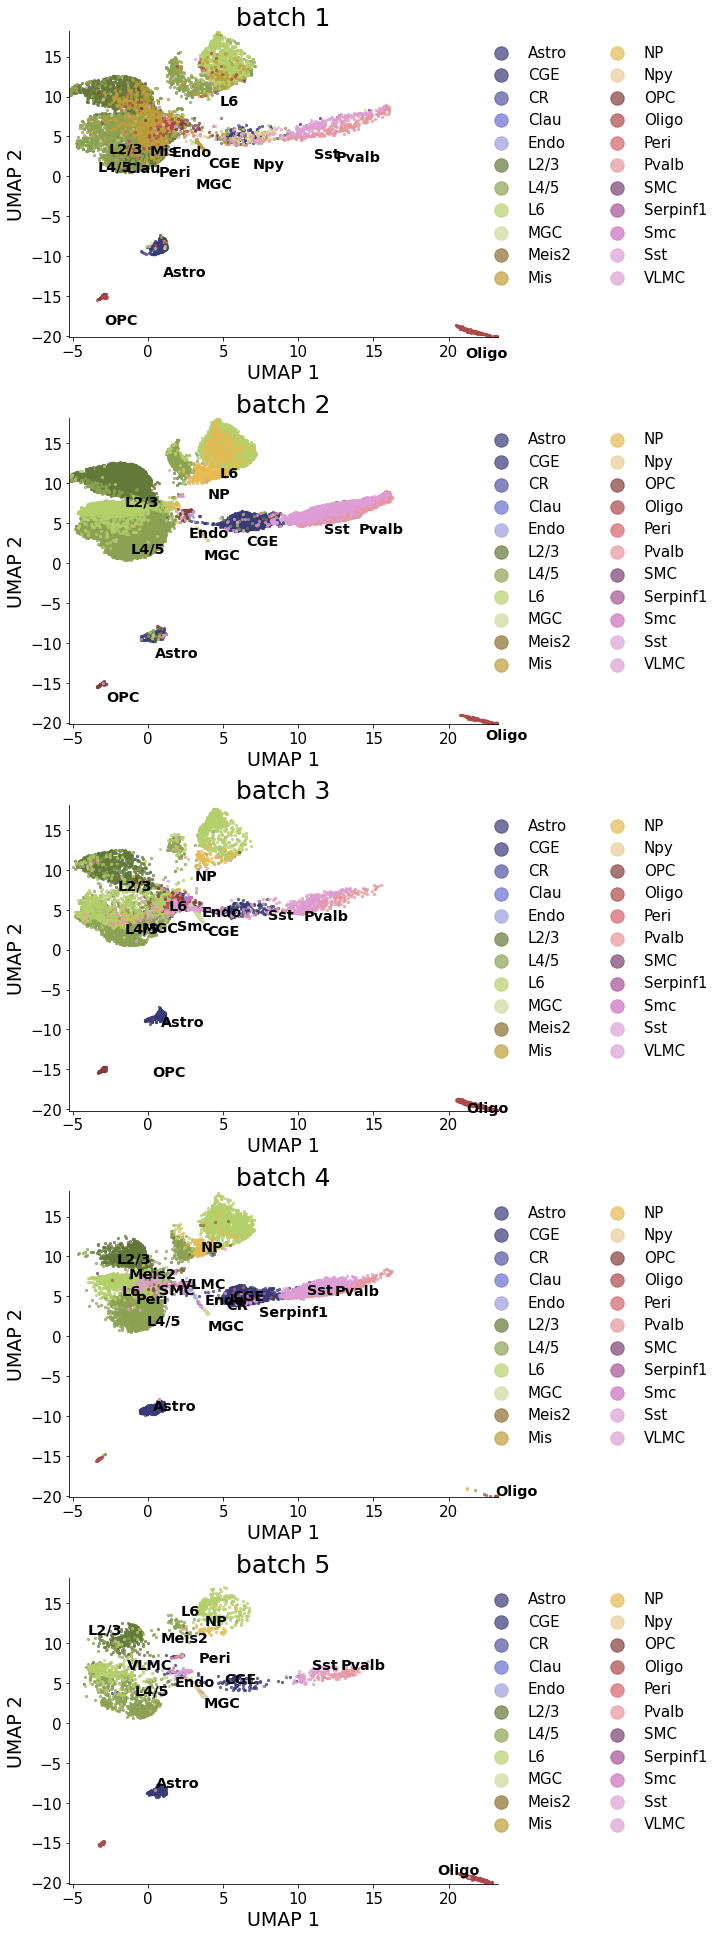

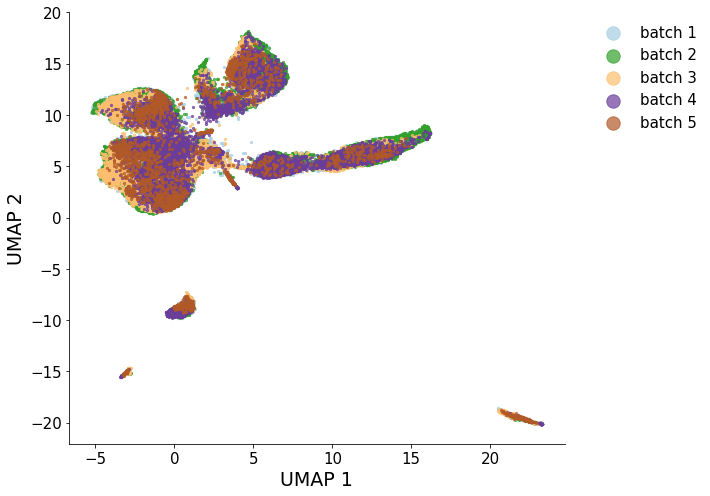

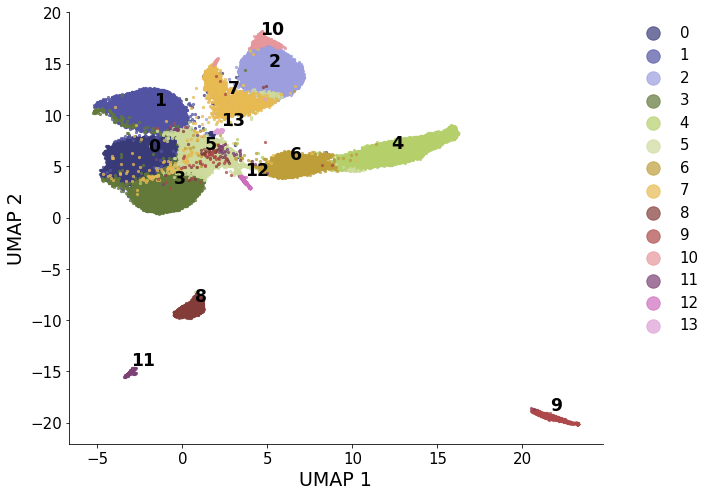

In [9]:
# NOTE: Post-processing, clustering, and plot the result after post-processing
n_neighbors = 50
r = None

zs = []
for batch in range(n_batches):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    zs.append(z)

s_pair_dist, knn_indices, knn_dists = utils.post_process(zs, n_neighbors, njobs = 8, r = r)

# scores = pd.read_csv(result_dir + "score.csv", index_col = 0)
# scores = scores[scores["methods"] == "scJMT"] 
# resolution = scores["resolution"].values[np.argmax(scores["NMI"].values.squeeze())]
# print(resolution)
resolution = 0.9
labels_tmp = utils.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
umap_op = umap_batch.UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)
x_umap = umap_op.fit_transform(s_pair_dist)

# np.save(result_dir + f'leiden_{K}_{T}_{resolution}.npy', labels_tmp)
# labels_tmp = np.load(result_dir + f'leiden_{K}_{T}_{resolution}.npy')

# separate into batches
x_umaps = []
leiden_labels = []
for batch in range(n_batches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])

    elif batch == (n_batches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
        leiden_labels.append(labels_tmp[start_pointer:])

    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])

utils.plot_latent_ext(x_umaps, annos = labels_remap, mode = "separate", save = None,\
                      figsize = (10,27), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = False, alpha = 0.7, text_size = "x-large")

utils.plot_latent_ext(x_umaps, annos = labels_remap, mode = "separate", save = None,\
                      figsize = (10,27), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True, alpha = 0.7, text_size = "x-large")

utils.plot_latent_ext(x_umaps, annos = labels_remap, mode = "modality", save = None,\
                      figsize = (10,7), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

utils.plot_latent_ext(x_umaps, annos = leiden_labels, mode = "joint", save = None,\
                      figsize = (10,7), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True, alpha = 0.7)



## Step 4: Retraining model
* If you have additional data matrices for the existing batches (e.g. motif matrix from chromVAR), you can insert the data matrices into `count` during that phase. The additional matrices are considered as new modalities, same requirements in step1 apply.
* If you don't have additional data matrice, you can directly go to the second cell below for retraining.

In [10]:
# read in motif dataset
counts_motifs = []
for batch in range(n_batches):    
    try:
        counts_motif = pd.read_csv(dir + f'MxC{batch+1}_raw.csv', index_col = 0).T
        # there might be small amount of na
        counts_motif = counts_motif.fillna(0)
        motifs = counts_motif.columns.values
        counts_motif = counts_motif.values
        # chromVAR provide the z-score, which has negative values
        counts_motif = (counts_motif - np.min(counts_motif))/(np.max(counts_motif) - np.min(counts_motif) + 1e-6)
    except:
        counts_motif = None
    
    counts_motifs.append(counts_motif)

counts["motif"] = counts_motifs
counts["feats_name"]["motif"] = motifs


Epoch 1, Validating Loss: 5920.5527
	 loss reconstruction: 0.40477
	 loss regularization: 551.57831
Epoch 1000, Validating Loss: 291.9585
	 loss reconstruction: 0.29182
	 loss regularization: 0.01363
Epoch 2000, Validating Loss: 291.7589
	 loss reconstruction: 0.29160
	 loss regularization: 0.01573


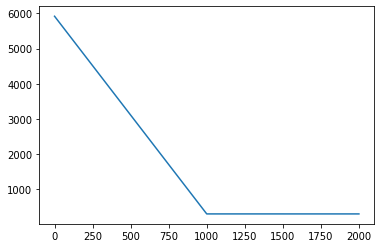

In [11]:
lamb = 0.01

# the leiden label is the one produced by the best resolution
model2 = model.scmomat_retrain(model = model1, counts =  counts, labels = leiden_labels, lamb = lamb, device = device)
losses = model2.train(T = 2000)

x = np.linspace(0, 2000, int(2000/interval) + 1)
plt.plot(x, losses)

C_feats = {}
for mod in model2.mods:
    C_feat = model2.softmax(model2.C_feats[mod]).data.cpu().numpy() @ model2.A_assos["shared"].data.cpu().numpy().T 
    C_feats[mod] = pd.DataFrame(data = C_feat, index = model2.feats_name[mod], columns = ["cluster_" + str(i) for i in range(C_feat.shape[1])])


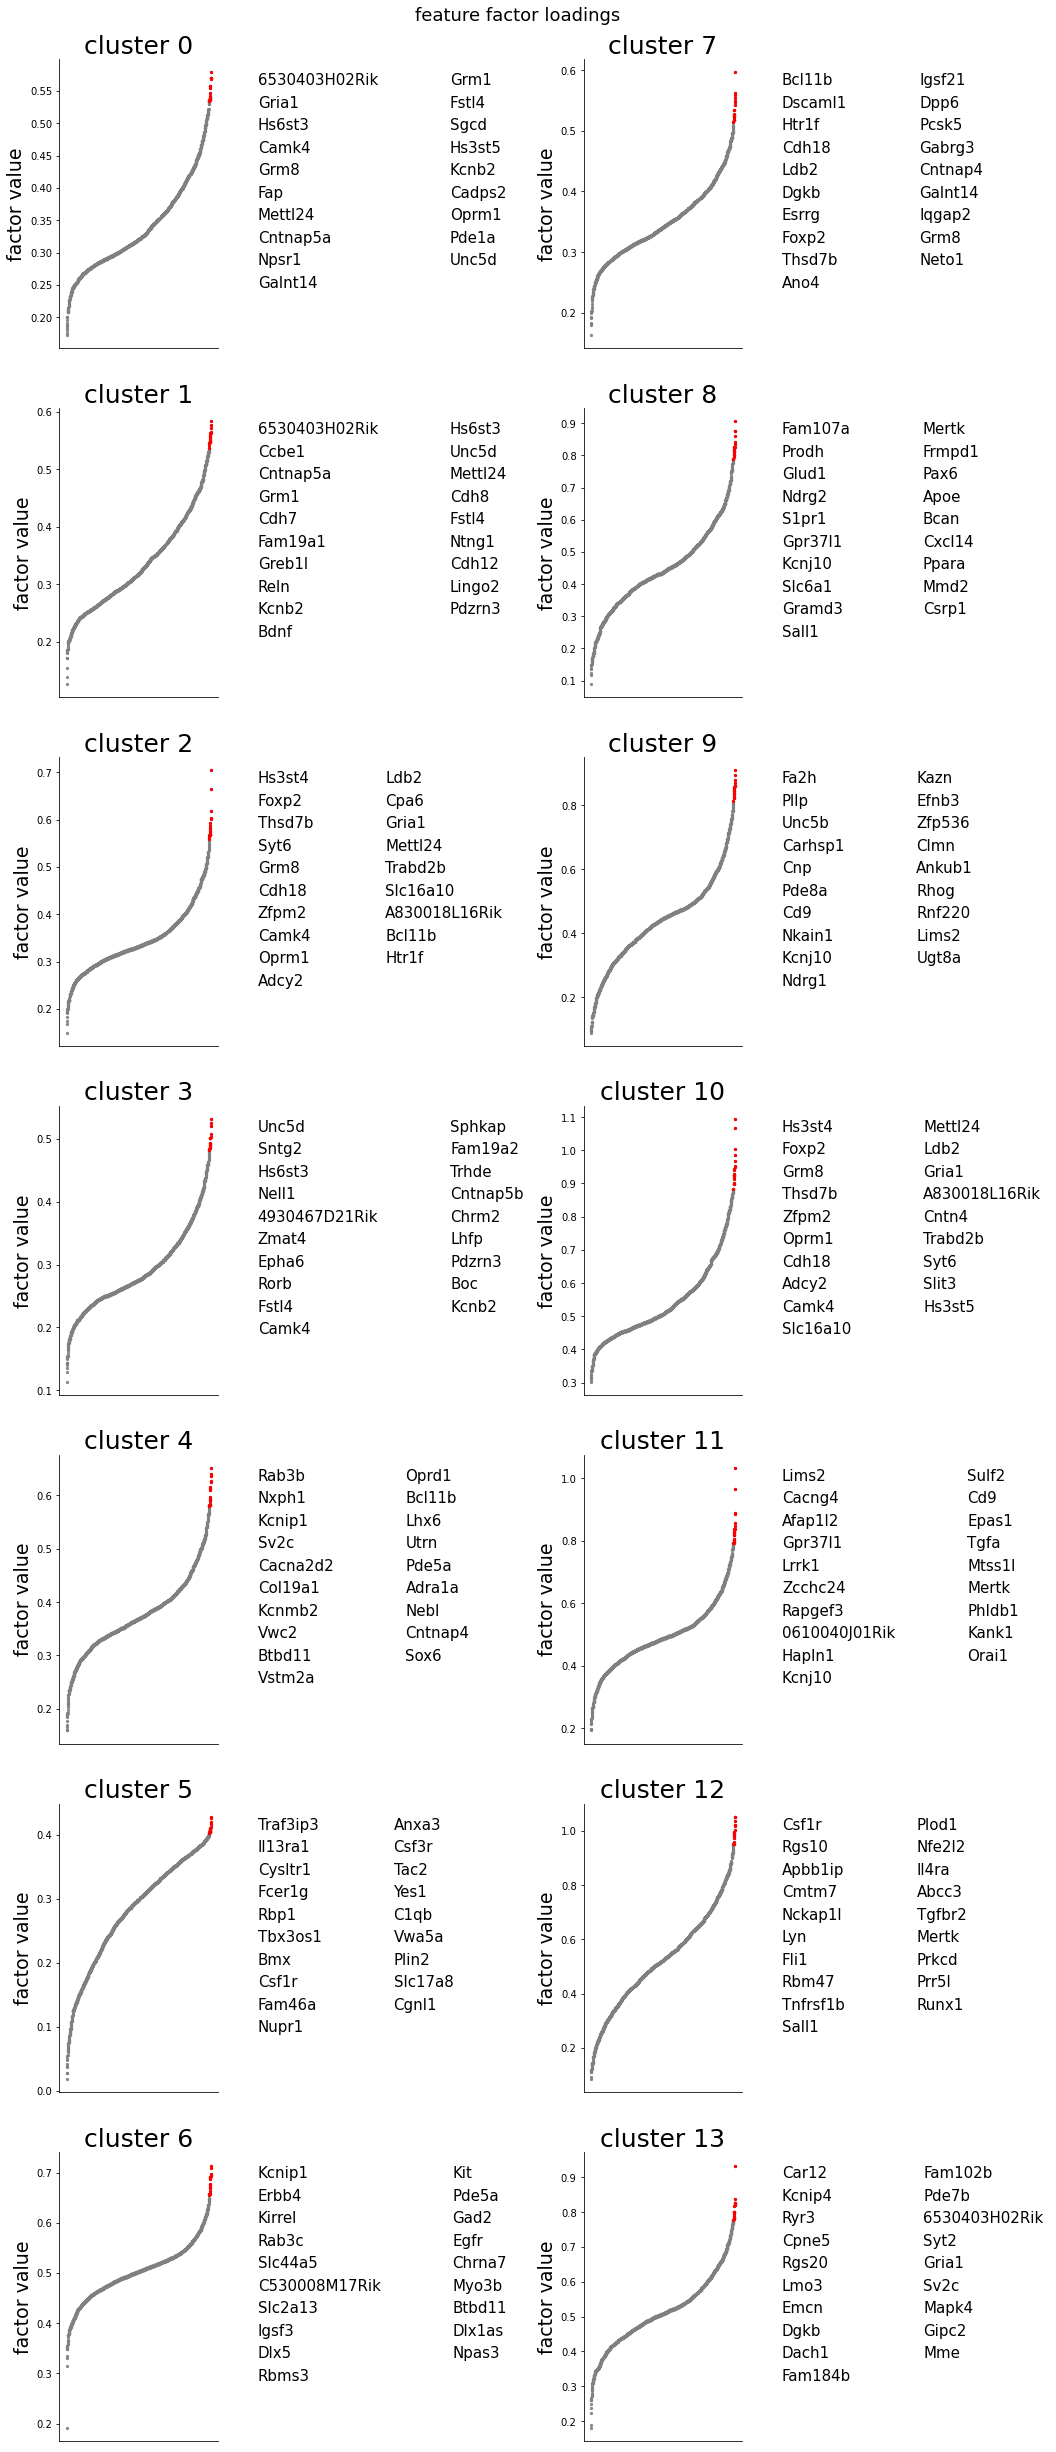

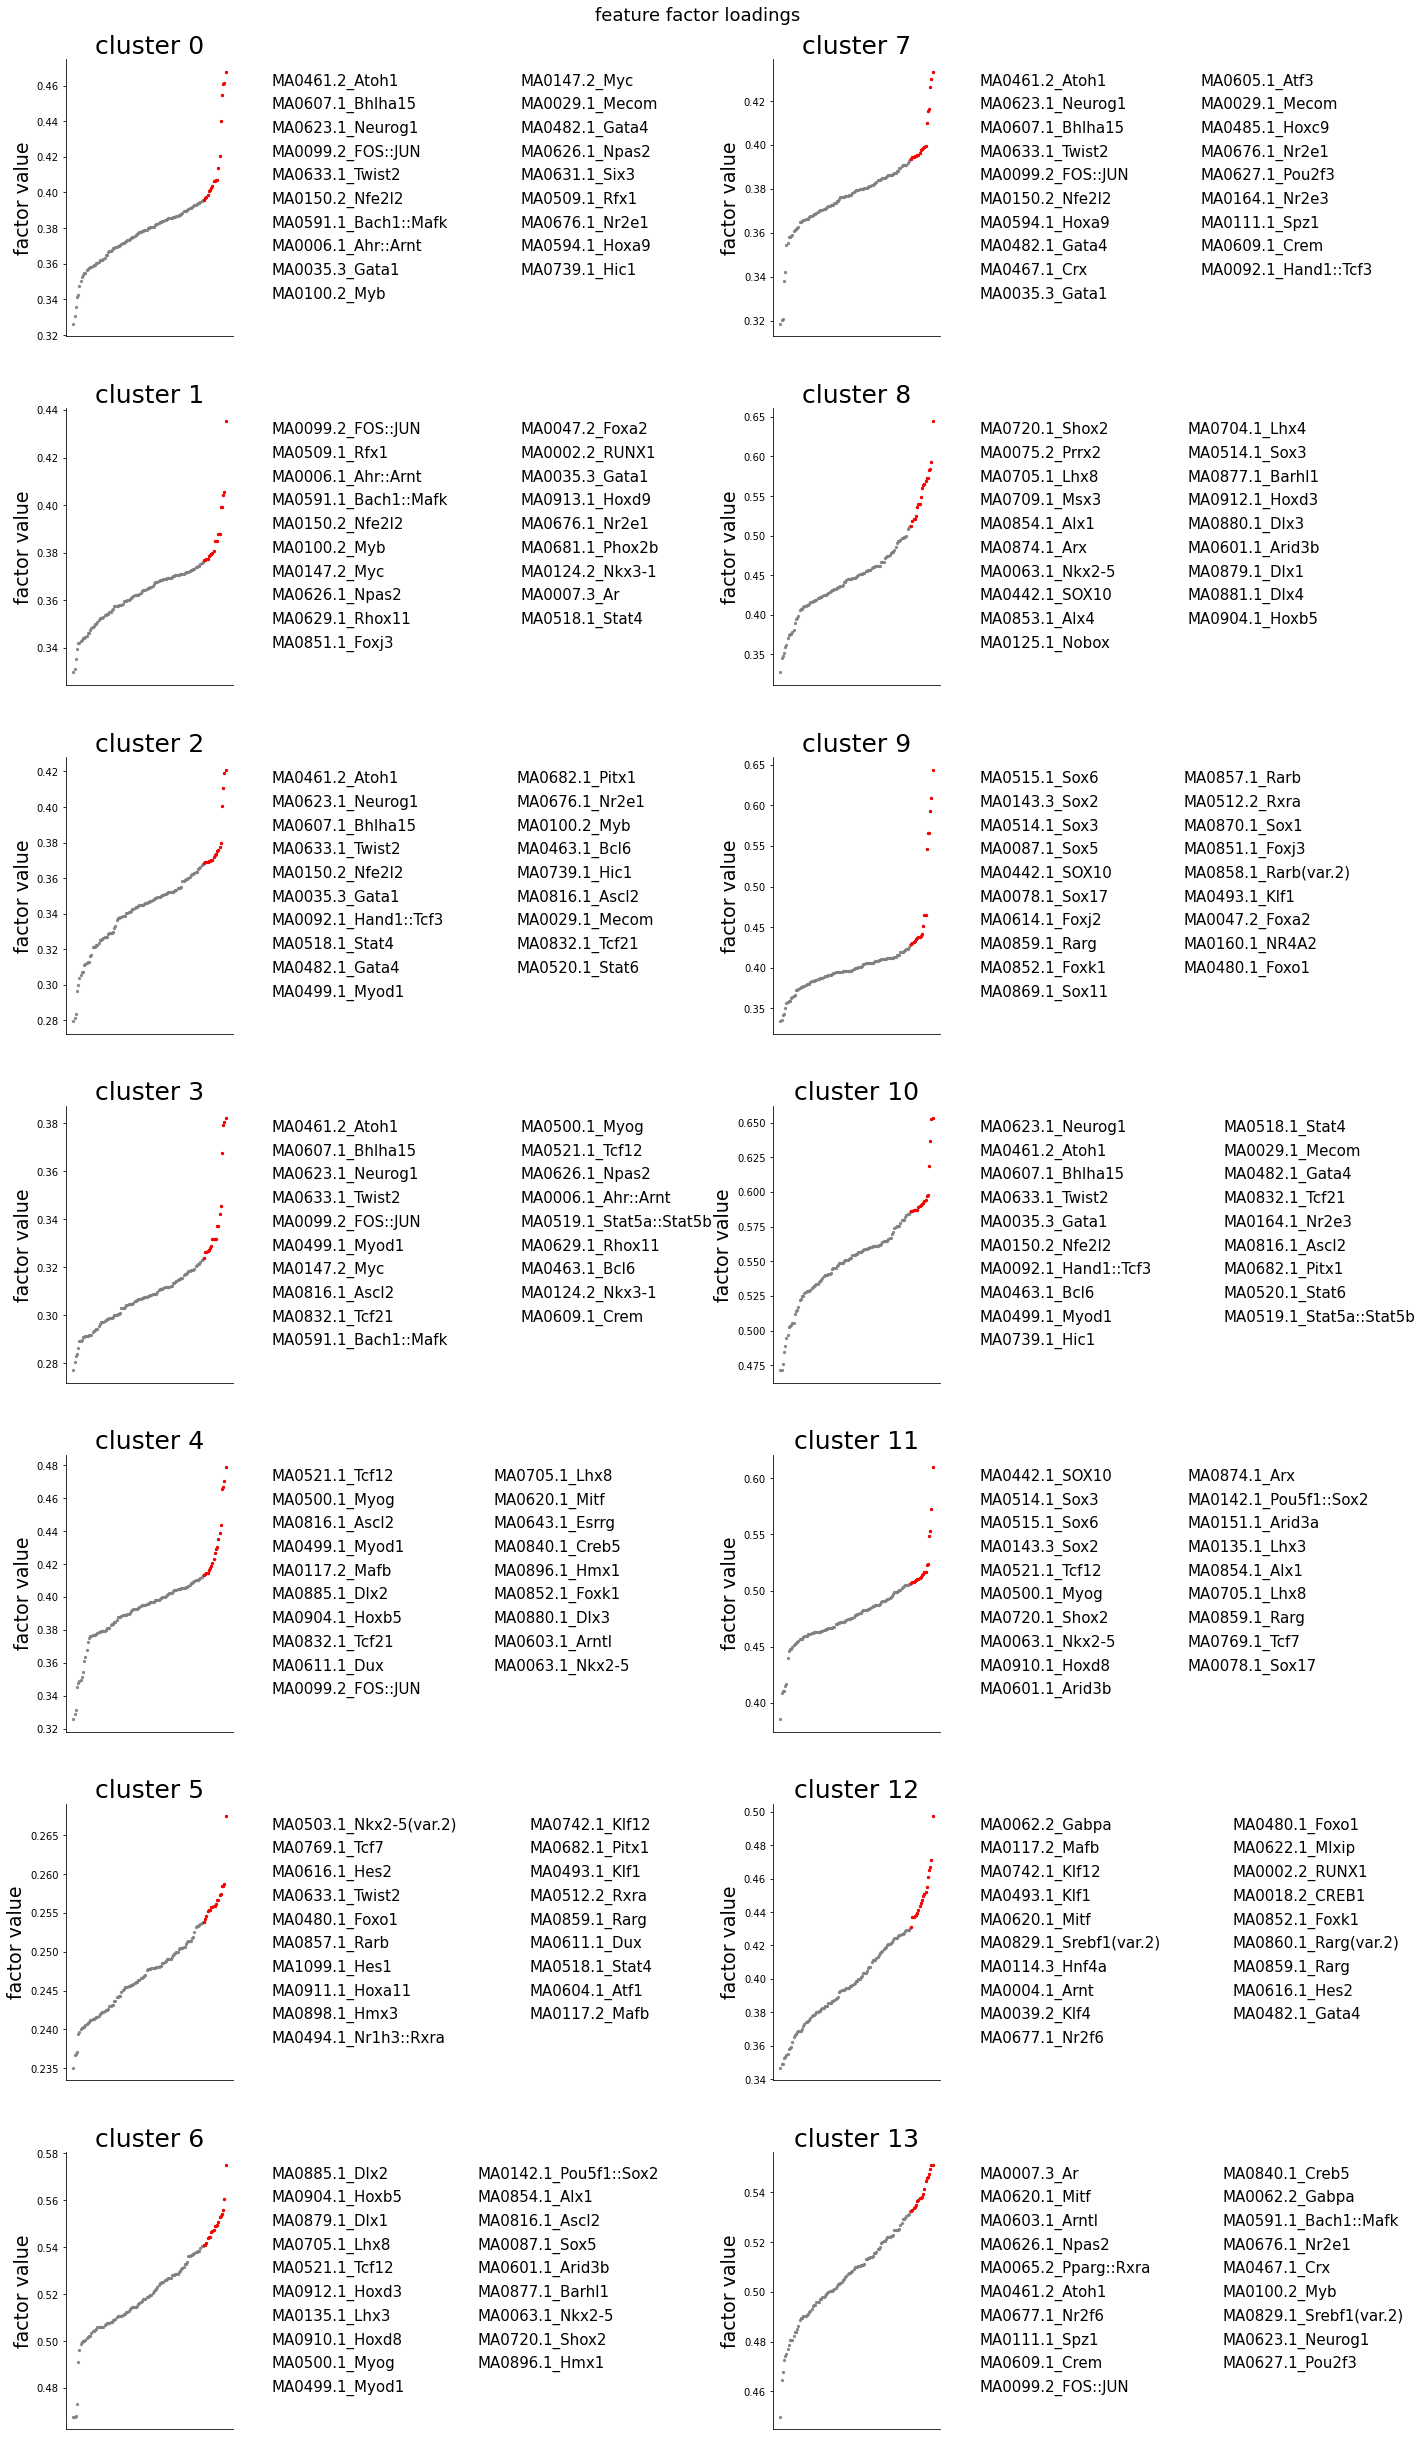

In [14]:
# Plot
C_gene = C_feats["rna"]
utils.plot_feat_score(C_gene, n_feats = 20, figsize= (15,35), save_as = None, title = "gene factor")

C_motif = C_feats["motif"]
utils.plot_feat_score(C_motif, n_feats = 20, figsize= (20,35), save_as = None, title = "motif factor")
